<a href="https://colab.research.google.com/github/victen18/Colab_Notebook_Projects/blob/main/C1W2_Ungraded_Lab_Birds_Cats_Dogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import shutil
import random
import zipfile
import tarfile
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

# To ignore some warnings about Image metadata that Pillow prints out
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Download datasets

# Cats and dogs
!wget https://storage.googleapis.com/mlep-public/course_1/week2/kagglecatsanddogs_3367a.zip

# Caltech birds
!wget https://storage.googleapis.com/mlep-public/course_1/week2/CUB_200_2011.tar

# Download pretrained models and training histories
!wget -q -P /content/model-balanced/ https://storage.googleapis.com/mlep-public/course_1/week2/model-balanced/saved_model.pb
!wget -q -P /content/model-balanced/variables/ https://storage.googleapis.com/mlep-public/course_1/week2/model-balanced/variables/variables.data-00000-of-00001
!wget -q -P /content/model-balanced/variables/ https://storage.googleapis.com/mlep-public/course_1/week2/model-balanced/variables/variables.index
!wget -q -P /content/history-balanced/ https://storage.googleapis.com/mlep-public/course_1/week2/history-balanced/history-balanced.csv

!wget -q -P /content/model-imbalanced/ https://storage.googleapis.com/mlep-public/course_1/week2/model-imbalanced/saved_model.pb
!wget -q -P /content/model-imbalanced/variables/ https://storage.googleapis.com/mlep-public/course_1/week2/model-imbalanced/variables/variables.data-00000-of-00001
!wget -q -P /content/model-imbalanced/variables/ https://storage.googleapis.com/mlep-public/course_1/week2/model-imbalanced/variables/variables.index
!wget -q -P /content/history-imbalanced/ https://storage.googleapis.com/mlep-public/course_1/week2/history-imbalanced/history-imbalanced.csv

!wget -q -P /content/model-augmented/ https://storage.googleapis.com/mlep-public/course_1/week2/model-augmented/saved_model.pb
!wget -q -P /content/model-augmented/variables/ https://storage.googleapis.com/mlep-public/course_1/week2/model-augmented/variables/variables.data-00000-of-00001
!wget -q -P /content/model-augmented/variables/ https://storage.googleapis.com/mlep-public/course_1/week2/model-augmented/variables/variables.index
!wget -q -P /content/history-augmented/ https://storage.googleapis.com/mlep-public/course_1/week2/history-augmented/history-augmented.csv

--2021-05-28 12:05:34--  https://storage.googleapis.com/mlep-public/course_1/week2/kagglecatsanddogs_3367a.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.204.128, 64.233.188.128, 64.233.189.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.204.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824894548 (787M) [application/zip]
Saving to: ‘kagglecatsanddogs_3367a.zip’

kagglecatsanddogs_3 100%[===================>] 786.68M  69.3MB/s    in 12s     

2021-05-28 12:05:47 (65.8 MB/s) - ‘kagglecatsanddogs_3367a.zip’ saved [824894548/824894548]

--2021-05-28 12:05:47--  https://storage.googleapis.com/mlep-public/course_1/week2/CUB_200_2011.tar
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.23.128, 74.125.203.128, 74.125.204.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.23.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1259479040 (

In [3]:
cats_and_dogs_zip = '/content/kagglecatsanddogs_3367a.zip'
caltech_birds_tar = '/content/CUB_200_2011.tar'

base_dir = '/tmp/data'

In [4]:
with zipfile.ZipFile(cats_and_dogs_zip, 'r') as my_zip:
  my_zip.extractall(base_dir)

In [5]:
with tarfile.open(caltech_birds_tar, 'r') as my_tar:
  my_tar.extractall(base_dir)

In [6]:
base_dogs_dir = os.path.join(base_dir, 'PetImages/Dog')
base_cats_dir = os.path.join(base_dir,'PetImages/Cat')

print(f"There are {len(os.listdir(base_dogs_dir))} images of dogs")
print(f"There are {len(os.listdir(base_cats_dir))} images of cats")

There are 12501 images of dogs
There are 12501 images of cats


In [7]:
raw_birds_dir = '/tmp/data/CUB_200_2011/images'
base_birds_dir = os.path.join(base_dir,'PetImages/Bird')
os.mkdir(base_birds_dir)

for subdir in os.listdir(raw_birds_dir):
  subdir_path = os.path.join(raw_birds_dir, subdir)
  for image in os.listdir(subdir_path):
    shutil.move(os.path.join(subdir_path, image), os.path.join(base_birds_dir))

print(f"There are {len(os.listdir(base_birds_dir))} images of birds")

There are 11788 images of birds


Sample cat image:


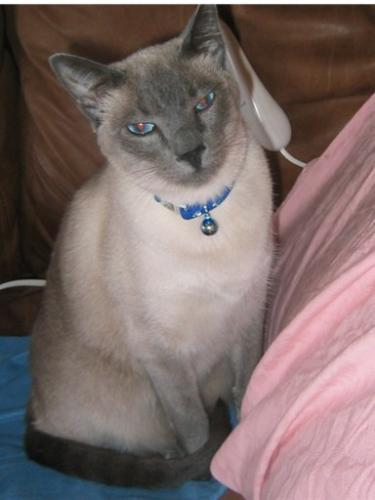


Sample dog image:


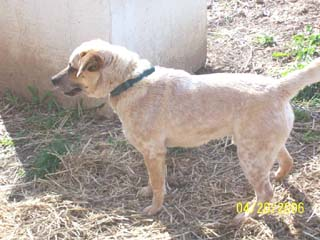


Sample bird image:


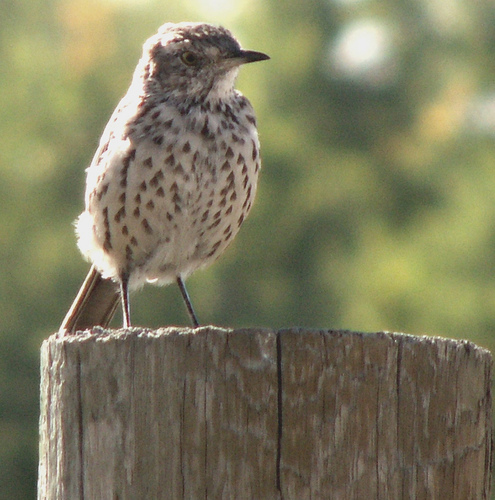

In [8]:
from IPython.display import Image, display

print("Sample cat image:")
display(Image(filename=f"{os.path.join(base_cats_dir, os.listdir(base_cats_dir)[0])}"))
print("\nSample dog image:")
display(Image(filename=f"{os.path.join(base_dogs_dir, os.listdir(base_dogs_dir)[0])}"))
print("\nSample bird image:")
display(Image(filename=f"{os.path.join(base_birds_dir, os.listdir(base_birds_dir)[0])}"))

In [9]:
train_eval_dirs = ['train/cats', 'train/dogs', 'train/birds',
                   'eval/cats', 'eval/dogs', 'eval/birds']

for dir in train_eval_dirs:
  if not os.path.exists(os.path.join(base_dir, dir)):
    os.makedirs(os.path.join(base_dir, dir))

In [10]:
def move_to_destination(origin, destination, percentage_split):
  num_images = int(len(os.listdir(origin))*percentage_split)
  for image_name, image_number in zip(sorted(os.listdir(origin)), range(num_images)):
    shutil.move(os.path.join(origin, image_name), destination)

In [11]:
# Move 70% of the images to the train dir
move_to_destination(base_cats_dir, os.path.join(base_dir, 'train/cats'), 0.7)
move_to_destination(base_dogs_dir, os.path.join(base_dir, 'train/dogs'), 0.7)
move_to_destination(base_birds_dir, os.path.join(base_dir, 'train/birds'), 0.7)


# Move the remaining images to the eval dir
move_to_destination(base_cats_dir, os.path.join(base_dir, 'eval/cats'), 1)
move_to_destination(base_dogs_dir, os.path.join(base_dir, 'eval/dogs'), 1)
move_to_destination(base_birds_dir, os.path.join(base_dir, 'eval/birds'), 1)

In [12]:
!find /tmp/data/ -size 0 -exec rm {} +
!find /tmp/data/ -type f ! -name "*.jpg" -exec rm {} +

In [13]:
print(f"There are {len(os.listdir(os.path.join(base_dir, 'train/cats')))} images of cats for training")
print(f"There are {len(os.listdir(os.path.join(base_dir, 'train/dogs')))} images of dogs for training")
print(f"There are {len(os.listdir(os.path.join(base_dir, 'train/birds')))} images of birds for training\n")

print(f"There are {len(os.listdir(os.path.join(base_dir, 'eval/cats')))} images of cats for evaluation")
print(f"There are {len(os.listdir(os.path.join(base_dir, 'eval/dogs')))} images of dogs for evaluation")
print(f"There are {len(os.listdir(os.path.join(base_dir, 'eval/birds')))} images of birds for evaluation")

There are 8750 images of cats for training
There are 8749 images of dogs for training
There are 8251 images of birds for training

There are 3749 images of cats for evaluation
There are 3750 images of dogs for evaluation
There are 3537 images of birds for evaluation


In [14]:
for dir in train_eval_dirs:
  if not os.path.exists(os.path.join(base_dir, 'imbalanced/'+dir)):
    os.makedirs(os.path.join(base_dir, 'imbalanced/'+dir))

In [15]:
# Very similar to the one used before but this one copies instead of moving
def copy_with_limit(origin, destination, percentage_split):
  num_images = int(len(os.listdir(origin))*percentage_split)
  for image_name, image_number in zip(sorted(os.listdir(origin)), range(num_images)):
    shutil.copy(os.path.join(origin, image_name), destination)

# Perform the copying
copy_with_limit(os.path.join(base_dir, 'train/cats'), os.path.join(base_dir, 'imbalanced/train/cats'), 1)
copy_with_limit(os.path.join(base_dir, 'train/dogs'), os.path.join(base_dir, 'imbalanced/train/dogs'), 0.2)
copy_with_limit(os.path.join(base_dir, 'train/birds'), os.path.join(base_dir, 'imbalanced/train/birds'), 0.1)

copy_with_limit(os.path.join(base_dir, 'eval/cats'), os.path.join(base_dir, 'imbalanced/eval/cats'), 1)
copy_with_limit(os.path.join(base_dir, 'eval/dogs'), os.path.join(base_dir, 'imbalanced/eval/dogs'), 0.2)
copy_with_limit(os.path.join(base_dir, 'eval/birds'), os.path.join(base_dir, 'imbalanced/eval/birds'), 0.1)

# Print number of available images
print(f"There are {len(os.listdir(os.path.join(base_dir, 'imbalanced/train/cats')))} images of cats for training")
print(f"There are {len(os.listdir(os.path.join(base_dir, 'imbalanced/train/dogs')))} images of dogs for training")
print(f"There are {len(os.listdir(os.path.join(base_dir, 'imbalanced/train/birds')))} images of birds for training\n")

print(f"There are {len(os.listdir(os.path.join(base_dir, 'imbalanced/eval/cats')))} images of cats for evaluation")
print(f"There are {len(os.listdir(os.path.join(base_dir, 'imbalanced/eval/dogs')))} images of dogs for evaluation")
print(f"There are {len(os.listdir(os.path.join(base_dir, 'imbalanced/eval/birds')))} images of birds for evaluation")

There are 8750 images of cats for training
There are 1749 images of dogs for training
There are 825 images of birds for training

There are 3749 images of cats for evaluation
There are 750 images of dogs for evaluation
There are 353 images of birds for evaluation


In [16]:
from tensorflow.keras import layers, models, optimizers

def create_model():
  # A simple CNN architecture based on the one found here: https://www.tensorflow.org/tutorials/images/classification
  model = models.Sequential([
  layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(64, (3, 3), activation='relu'),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(64, (3, 3), activation='relu'),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(128, (3, 3), activation='relu'),
  layers.MaxPooling2D((2, 2)),
  layers.Flatten(),
  layers.Dense(512, activation='relu'),
  layers.Dense(3, activation='softmax')
  ])


  # Compile the model
  model.compile(
      loss=tf.keras.losses.SparseCategoricalCrossentropy(),
      optimizer=optimizers.Adam(),
      metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
  )

  return model

In [17]:
# Create a model to use with the imbalanced dataset
imbalanced_model = create_model()

# Print the model's summary
print(imbalanced_model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       7

In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# No data augmentation for now, only normalizing pixel values
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Point to the imbalanced directory
train_generator = train_datagen.flow_from_directory(
        '/tmp/data/imbalanced/train',
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        '/tmp/data/imbalanced/eval',
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

Found 11324 images belonging to 3 classes.
Found 4852 images belonging to 3 classes.


In [19]:
print(f"labels for each class in the train generator are: {train_generator.class_indices}")
print(f"labels for each class in the validation generator are: {validation_generator.class_indices}")

labels for each class in the train generator are: {'birds': 0, 'cats': 1, 'dogs': 2}
labels for each class in the validation generator are: {'birds': 0, 'cats': 1, 'dogs': 2}


In [20]:
# Load pretrained model and history

imbalanced_history = pd.read_csv('history-imbalanced/history-imbalanced.csv')
imbalanced_model = tf.keras.models.load_model('model-imbalanced')

In [21]:
def get_training_metrics(history):
  
  # This is needed depending on if you used the pretrained model or you trained it yourself
  if not isinstance(history, pd.core.frame.DataFrame):
    history = history.history
  
  acc = history['sparse_categorical_accuracy']
  val_acc = history['val_sparse_categorical_accuracy']

  loss = history['loss']
  val_loss = history['val_loss']

  return acc, val_acc, loss, val_loss

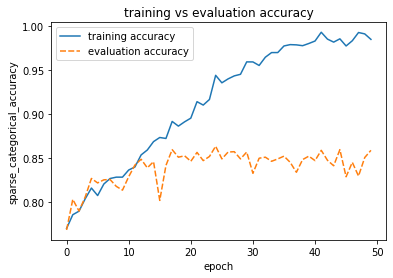

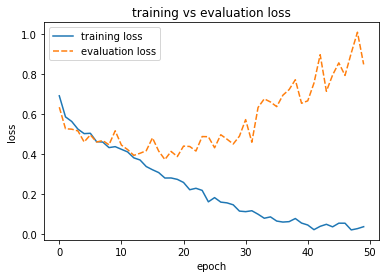

In [22]:
def plot_train_eval(history):
  acc, val_acc, loss, val_loss = get_training_metrics(history)

  acc_plot = pd.DataFrame({"training accuracy":acc, "evaluation accuracy":val_acc})
  acc_plot = sns.lineplot(data=acc_plot)
  acc_plot.set_title('training vs evaluation accuracy')
  acc_plot.set_xlabel('epoch')
  acc_plot.set_ylabel('sparse_categorical_accuracy')
  plt.show()

  print("")

  loss_plot = pd.DataFrame({"training loss":loss, "evaluation loss":val_loss})
  loss_plot = sns.lineplot(data=loss_plot)
  loss_plot.set_title('training vs evaluation loss')
  loss_plot.set_xlabel('epoch')
  loss_plot.set_ylabel('loss')
  plt.show()



plot_train_eval(imbalanced_history)

In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, balanced_accuracy_score

In [24]:
# Use the validation generator without shuffle to easily compute additional metrics
val_gen_no_shuffle = test_datagen.flow_from_directory(
    '/tmp/data/imbalanced/eval',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    shuffle=False)

Found 4852 images belonging to 3 classes.


In [25]:
# Get the true labels from the generator
y_true = val_gen_no_shuffle.classes

# Use the model to predict (will take a couple of minutes)
predictions_imbalanced = imbalanced_model.predict(val_gen_no_shuffle)

# Get the argmax (since softmax is being used)
y_pred_imbalanced = np.argmax(predictions_imbalanced, axis=1)

# Print accuracy score
print(f"Accuracy Score: {accuracy_score(y_true, y_pred_imbalanced)}")

# Print balanced accuracy score
print(f"Balanced Accuracy Score: {balanced_accuracy_score(y_true, y_pred_imbalanced)}")

Accuracy Score: 0.855111294311624
Balanced Accuracy Score: 0.7417486453422518


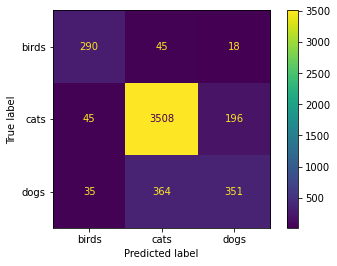

In [26]:
imbalanced_cm = confusion_matrix(y_true, y_pred_imbalanced)
ConfusionMatrixDisplay(imbalanced_cm, display_labels=['birds', 'cats', 'dogs']).plot(values_format="d")

In [27]:
misclassified_birds = (imbalanced_cm[1,0] + imbalanced_cm[2,0])/np.sum(imbalanced_cm, axis=0)[0]
misclassified_cats = (imbalanced_cm[0,1] + imbalanced_cm[2,1])/np.sum(imbalanced_cm, axis=0)[1]
misclassified_dogs = (imbalanced_cm[0,2] + imbalanced_cm[1,2])/np.sum(imbalanced_cm, axis=0)[2]

print(f"Proportion of misclassified birds: {misclassified_birds*100:.2f}%")
print(f"Proportion of misclassified cats: {misclassified_cats*100:.2f}%")
print(f"Proportion of misclassified dogs: {misclassified_dogs*100:.2f}%")

Proportion of misclassified birds: 21.62%
Proportion of misclassified cats: 10.44%
Proportion of misclassified dogs: 37.88%


In [28]:
# Predict cat for all images
all_cats = np.ones(y_true.shape)

# Print accuracy score
print(f"Accuracy Score: {accuracy_score(y_true, all_cats)}")

# Print balanced accuracy score
print(f"Balanced Accuracy Score: {balanced_accuracy_score(y_true, all_cats)}")

Accuracy Score: 0.7726710634789777
Balanced Accuracy Score: 0.3333333333333333


Found 11036 images belonging to 3 classes.


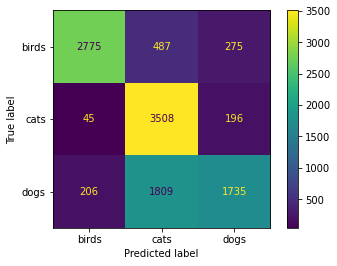

In [29]:
# Use the validation generator without shuffle to easily compute additional metrics
val_gen_no_shuffle = test_datagen.flow_from_directory(
    '/tmp/data/eval',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    shuffle=False)

# Get the true labels from the generator
y_true = val_gen_no_shuffle.classes

# Use the model to predict (will take a couple of minutes)
predictions_imbalanced = imbalanced_model.predict(val_gen_no_shuffle)

# Get the argmax (since softmax is being used)
y_pred_imbalanced = np.argmax(predictions_imbalanced, axis=1)

# Confusion matrix
imbalanced_cm = confusion_matrix(y_true, y_pred_imbalanced)
ConfusionMatrixDisplay(imbalanced_cm, display_labels=['birds', 'cats', 'dogs']).plot(values_format="d")

In [30]:
# Create a model to use with the balanced dataset
balanced_model = create_model()

In [31]:
# Still no data augmentation, only re-scaling
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Generators now point to the complete dataset
train_generator = train_datagen.flow_from_directory(
        '/tmp/data/train',
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        '/tmp/data/eval',
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

Found 25750 images belonging to 3 classes.
Found 11036 images belonging to 3 classes.


In [32]:
# Load pretrained model and history

balanced_history = pd.read_csv('history-balanced/history-balanced.csv')
balanced_model = tf.keras.models.load_model('model-balanced')

In [33]:
# Use the validation generator without shuffle to easily compute additional metrics
val_gen_no_shuffle = test_datagen.flow_from_directory(
    '/tmp/data/eval',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    shuffle=False)

Found 11036 images belonging to 3 classes.


In [34]:
# Get the true labels from the generator
y_true = val_gen_no_shuffle.classes

# Use the model to predict (will take a couple of minutes)
predictions_balanced = balanced_model.predict(val_gen_no_shuffle)

# Get the argmax (since softmax is being used)
y_pred_balanced = np.argmax(predictions_balanced, axis=1)

# Print accuracy score
print(f"Accuracy Score: {accuracy_score(y_true, y_pred_balanced)}")

# Print balanced accuracy score
print(f"Balanced Accuracy Score: {balanced_accuracy_score(y_true, y_pred_balanced)}")

Accuracy Score: 0.8636281261326567
Balanced Accuracy Score: 0.8647221799730266


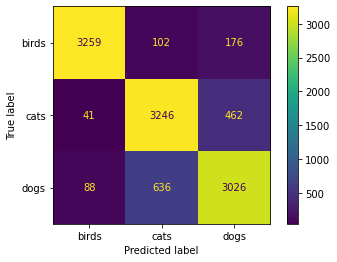

In [35]:
balanced_cm = confusion_matrix(y_true, y_pred_balanced)
ConfusionMatrixDisplay(balanced_cm, display_labels=['birds', 'cats', 'dogs']).plot(values_format="d")

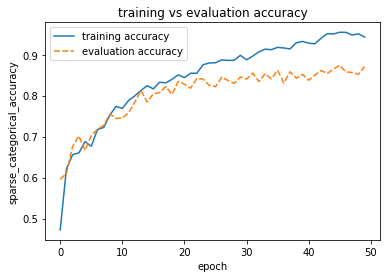

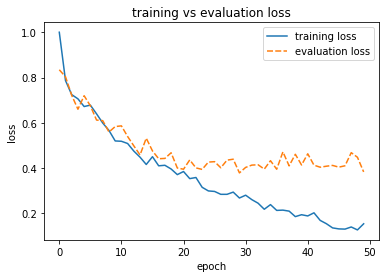

In [36]:
plot_train_eval(balanced_history)

In [37]:
# Create a model to use with the balanced and augmented dataset
augmented_model = create_model()

In [38]:
# Now applying image augmentation
train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=50,
        width_shift_range=0.15,
        height_shift_range=0.15,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)


test_datagen = ImageDataGenerator(rescale=1./255)

# Still pointing to directory with full dataset
train_generator = train_datagen.flow_from_directory(
        '/tmp/data/train',
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        '/tmp/data/eval',
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

Found 25750 images belonging to 3 classes.
Found 11036 images belonging to 3 classes.



Transformation number: 0



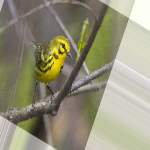


Transformation number: 1



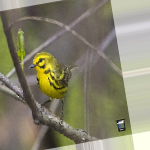


Transformation number: 2



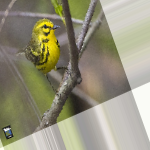


Transformation number: 3



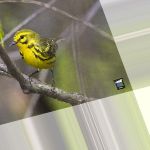

In [39]:
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img, load_img


# Displays transformations on random images of birds in the training partition
def display_transformations(gen):
  train_birds_dir = "/tmp/data/train/birds"
  random_index = random.randint(0, len(os.listdir(train_birds_dir)))
  sample_image = load_img(f"{os.path.join(train_birds_dir, os.listdir(train_birds_dir)[random_index])}", target_size=(150, 150))
  sample_array = img_to_array(sample_image)
  sample_array = sample_array[None, :]


  for iteration, array in zip(range(4), gen.flow(sample_array, batch_size=1)):
    array = np.squeeze(array)
    img = array_to_img(array)
    print(f"\nTransformation number: {iteration}\n")
    display(img)


# An example of an ImageDataGenerator
sample_gen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=50,
        width_shift_range=0.25,
        height_shift_range=0.25,
        shear_range=0.2,
        zoom_range=0.25,
        horizontal_flip=True)

display_transformations(sample_gen)


Transformation number: 0



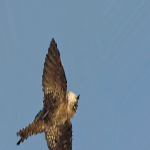


Transformation number: 1



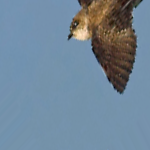


Transformation number: 2



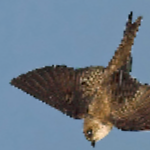


Transformation number: 3



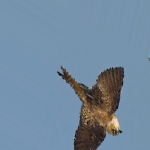

In [40]:
# An ImageDataGenerator with more extreme data augmentation
sample_gen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=90,
        width_shift_range=0.3,
        height_shift_range=0.3,
        shear_range=0.5,
        zoom_range=0.5,
        vertical_flip=True,
        horizontal_flip=True)

display_transformations(sample_gen)

In [41]:
# Load pretrained model and history

augmented_history = pd.read_csv('history-augmented/history-augmented.csv')
augmented_model = tf.keras.models.load_model('model-augmented')

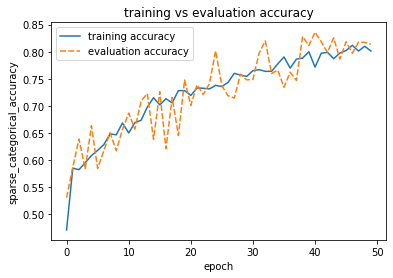

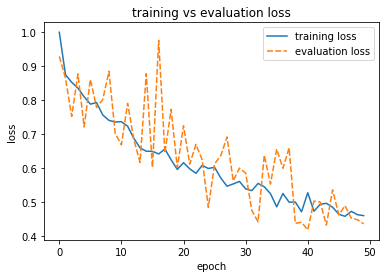

In [42]:
plot_train_eval(augmented_history)